<a href="https://colab.research.google.com/github/wolfzxcv/ml-examples/blob/master/SBS_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
dataset = load_breast_cancer()
X = dataset.data
y = dataset.target
feature_names = dataset.feature_names

In [32]:
# Export .csv to see the data, you don't need these few lines
import pandas as pd

# Create a DataFrame with the features
df = pd.DataFrame(data=X, columns=feature_names)

# Add the target variable as the last column
df['target'] = y

# Export the DataFrame to a CSV file
df.to_csv('breast_cancer.csv', sep=',', index=False)

Support Vector Classifier:
  All Features Accuracy: 0.9122807017543859
  Selected Features Accuracy: 0.9473684210526315
  Number of selected features: 15
  Selected features: smoothness error, compactness error, concavity error, concave points error, symmetry error, fractal dimension error, worst radius, worst texture, worst perimeter, worst smoothness, worst compactness, worst concavity, worst concave points, worst symmetry, worst fractal dimension

Confusion Matrix:
Predicted Label  Malignant  Benign
True Label                        
Malignant               36       6
Benign                   0      72

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        42
           1       0.92      1.00      0.96        72

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



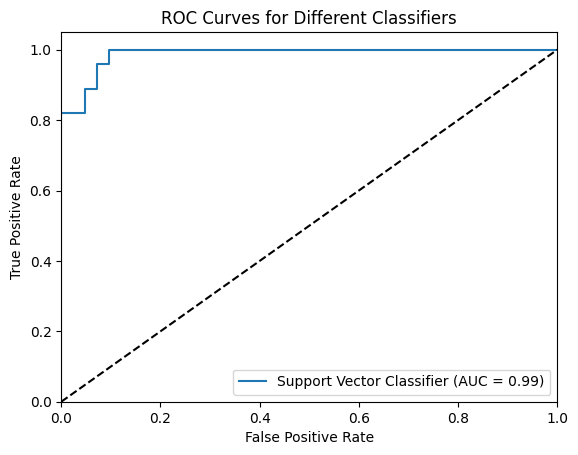

--------------------------------------------------------------
Random Forest:
  All Features Accuracy: 0.9736842105263158
  Selected Features Accuracy: 0.9649122807017544
  Number of selected features: 15
  Selected features: mean smoothness, mean concave points, texture error, perimeter error, area error, smoothness error, compactness error, concavity error, fractal dimension error, worst radius, worst texture, worst area, worst concavity, worst symmetry, worst fractal dimension

Confusion Matrix:
Predicted Label  Malignant  Benign
True Label                        
Malignant               39       3
Benign                   1      71

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



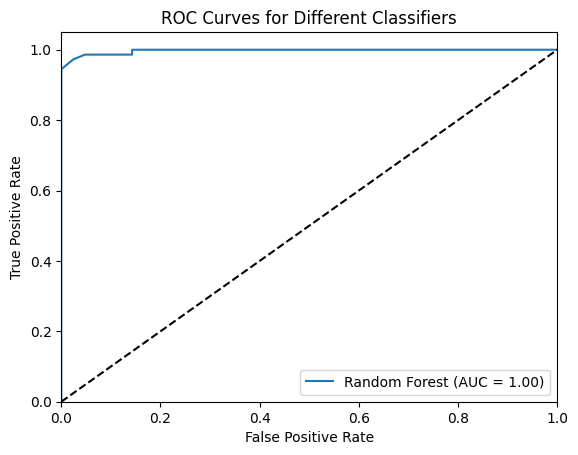

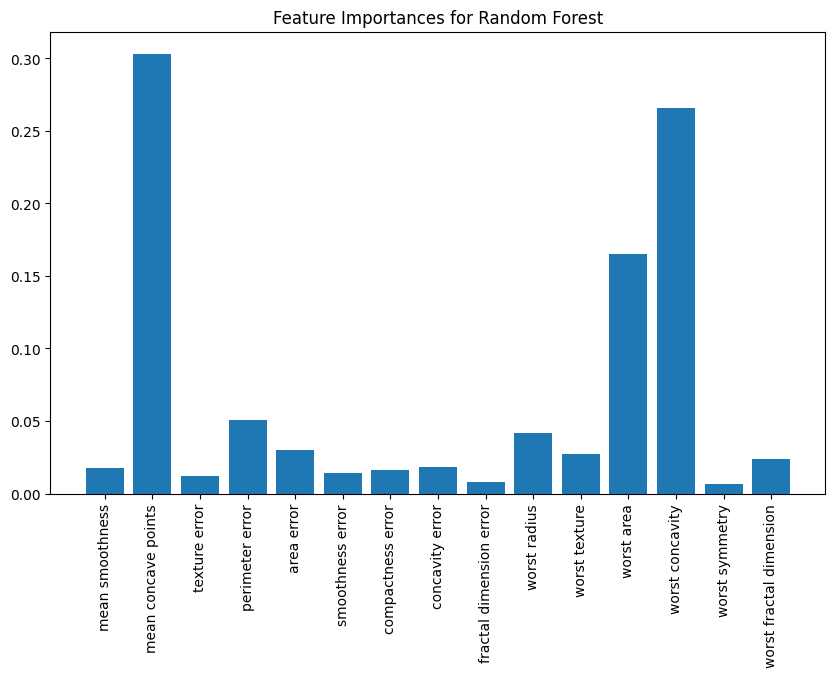

--------------------------------------------------------------
Logistic Regression:
  All Features Accuracy: 0.956140350877193
  Selected Features Accuracy: 0.956140350877193
  Number of selected features: 15
  Selected features: mean texture, mean concavity, mean fractal dimension, radius error, texture error, smoothness error, concavity error, fractal dimension error, worst radius, worst area, worst smoothness, worst concavity, worst concave points, worst symmetry, worst fractal dimension

Confusion Matrix:
Predicted Label  Malignant  Benign
True Label                        
Malignant               38       4
Benign                   1      71

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96      

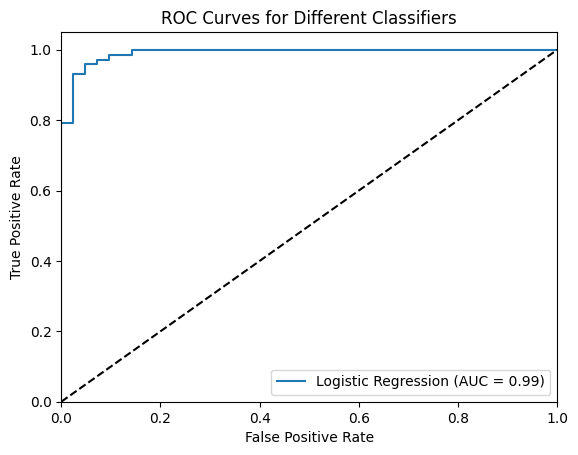

--------------------------------------------------------------


In [33]:
# Split data
RANDOM_STATE = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Define classifiers
classifiers = [
    ('Support Vector Classifier', SVC(probability=True, random_state=RANDOM_STATE)),
    ('Random Forest', RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)),
    ('Logistic Regression', LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)),
]

plt.figure()
for name, clf in classifiers:
    # Feature selection
    sfs = SequentialFeatureSelector(clf, direction='backward', n_features_to_select='auto')
    sfs.fit(X_train, y_train)
    selected_feature_names = feature_names[sfs.get_support()]
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)

    # Train on all features
    clf.fit(X_train, y_train)
    y_pred_all_features = clf.predict(X_test)
    accuracy_all_features = accuracy_score(y_test, y_pred_all_features)

    # Train on selected features
    clf.fit(X_train_selected, y_train)
    y_pred_selected = clf.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)

    print(f'{name}:')
    print(f'  All Features Accuracy: {accuracy_all_features}')
    print(f'  Selected Features Accuracy: {accuracy_selected}')
    print(f'  Number of selected features: {len(selected_feature_names)}')
    print(f'  Selected features: {", ".join(selected_feature_names)}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred_selected)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Malignant', 'Benign'], columns=['Malignant', 'Benign'])
    conf_matrix_df.index.name = "True Label"
    conf_matrix_df.columns.name = "Predicted Label"
    print('\nConfusion Matrix:')
    print(conf_matrix_df)
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred_selected))

    # ROC curve and ROC AUC
    y_proba_selected = clf.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_selected)
    roc_auc = roc_auc_score(y_test, y_proba_selected)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Finalize ROC curve plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Classifiers')
    plt.legend(loc='lower right')
    plt.show()

    # Feature importance for Random Forest
    if name == 'Random Forest':
        importances = clf.feature_importances_
        indices = range(len(importances))
        plt.figure(figsize=(10, 6))
        plt.bar(indices, importances, align='center')
        plt.xticks(indices, selected_feature_names, rotation=90)
        plt.title('Feature Importances for Random Forest')
        plt.show()

    print('--------------------------------------------------------------')